In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

dataset = pd.read_csv("../data/cleanData.csv")

In [2]:
dataset.head(2)

,Unnamed: 0,accession_number,artist,title,date,decade,country,collection,sight,length,...,abrasions_frame,flaking_frame,losses_frame,dented_frame,chipped_frame,cracking_frame,corner_damage_frame,mitres_separating_frame,work_loose_frame,surface_dirt_along_top_edge_frame
0,0,Upvma-Iii.00240,"Gallardo, Alladin",Ifugao Warrior,1947,1940,Philippines,Vargas Museum (Philippines),635X 480,635.00,...,1,0,1,1,1,0,1,0,0,0
1,1,Upvma-Iii.00085,"Ancheta, Isidro",Guadalupe Ruins,1939,1930,Philippines,Vargas Museum (Philippines),670 X 405,670.00,...,1,0,0,1,0,0,1,0,0,0


Predicting `ground_layer_application`

In [3]:
dataset['ground_condition'] = dataset['ground_condition'].fillna('Condition Unspecified')
colnames = ['ground_layer_application', 'ground_layer_limit', 'ground_layer_thickness', 'size_layer_visible', 'ground_condition',
            'coloured_ground', 'id_sulphate', 'id_carbonate', 'uniform_application', 'ground_proprietary_paint', 'collection']

One hot encode categorical data with more than two values

In [4]:
prediction_set = dataset[colnames]
one_hot = pd.get_dummies(prediction_set['ground_layer_limit'])
prediction_set = prediction_set.drop('ground_layer_limit', axis=1)
prediction_set = prediction_set.join(one_hot)

one_hot = pd.get_dummies(prediction_set['ground_layer_thickness'])
prediction_set = prediction_set.drop('ground_layer_thickness', axis=1)
prediction_set = prediction_set.join(one_hot, lsuffix="limit", rsuffix="thickness")

one_hot = pd.get_dummies(prediction_set['collection'])
prediction_set = prediction_set.drop('collection', axis=1)
prediction_set = prediction_set.join(one_hot)

one_hot = pd.get_dummies(prediction_set['ground_condition'])
prediction_set = prediction_set.drop('ground_condition', axis=1)
prediction_set = prediction_set.join(one_hot)
prediction_set.columns = prediction_set.columns.astype(str)

Split data into training, validation and testing set

In [5]:
prediction_set.ground_layer_application

0                Unspecified
1      Artist Applied Ground
2      Artist Applied Ground
3      Artist Applied Ground
4          Commercial Ground
               ...          
203        Commercial Ground
204        Commercial Ground
205        Commercial Ground
206        Commercial Ground
207    Artist Applied Ground
Name: ground_layer_application, Length: 208, dtype: object

In [6]:
X = prediction_set[(prediction_set['ground_layer_application'] != 'Unspecified') & (prediction_set['ground_layer_application'] != 'Unsure')]
test = prediction_set[(prediction_set['ground_layer_application'] == 'Unspecified') | (prediction_set['ground_layer_application'] == 'Unsure')]

Perform train validation split

In [7]:
y = X.ground_layer_application
X = X.drop('ground_layer_application', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=25)

In [8]:
X_test = test.drop('ground_layer_application', axis=1)

In [9]:
X_train.shape, X_valid.shape

((128, 23), (56, 23))

In [10]:
X_test.shape

(24, 23)

### Train baseline model: Bernoulli Naive Bayes

In [11]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [12]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
valid_prediction = bnb.predict(X_valid)
test_prediction = bnb.predict(X_test)
print("Training Accuracy:", bnb.score(X_train, y_train))
print("Holdout Accuracy:", bnb.score(X_valid, y_valid))

Training Accuracy: 0.7890625
Holdout Accuracy: 0.7321428571428571


In [13]:
print("Training data class distribution: ", Counter(y_train))
print("Validation data class distribution: ", Counter(y_valid))
print("Validation prediction distribution: ", Counter(valid_prediction))

Training data class distribution:  Counter({'Artist Applied Ground': 68, 'Commercial Ground': 60})
Validation data class distribution:  Counter({'Commercial Ground': 34, 'Artist Applied Ground': 22})
Validation prediction distribution:  Counter({'Commercial Ground': 35, 'Artist Applied Ground': 21})


Evaluate using confusion matrix

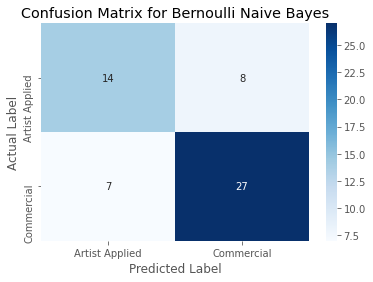

In [14]:
cm = confusion_matrix(y_valid, valid_prediction)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = ['Artist Applied', 'Commercial'],
            yticklabels = ['Artist Applied', 'Commercial'])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix for Bernoulli Naive Bayes')
plt.show()

Print predictions

In [15]:
bnb_prediction = test_prediction
bnb_prediction

array(['Commercial Ground', 'Commercial Ground', 'Commercial Ground',
       'Commercial Ground', 'Commercial Ground', 'Commercial Ground',
       'Artist Applied Ground', 'Commercial Ground',
       'Artist Applied Ground', 'Commercial Ground', 'Commercial Ground',
       'Commercial Ground', 'Commercial Ground', 'Artist Applied Ground',
       'Commercial Ground', 'Artist Applied Ground',
       'Artist Applied Ground', 'Commercial Ground', 'Commercial Ground',
       'Commercial Ground', 'Commercial Ground', 'Commercial Ground',
       'Artist Applied Ground', 'Commercial Ground'], dtype='<U21')

### Train Support Vector Machine

Without hyperparameter tuning

In [16]:
from sklearn.svm import SVC


svm = SVC(C=0.126896)
svm.fit(X_train, y_train)
valid_prediction = svm.predict(X_valid)
test_prediction = svm.predict(X_test)
print("Training Accuracy:", svm.score(X_train, y_train))
print("Holdout Accuracy:", svm.score(X_valid, y_valid))

Training Accuracy: 0.765625
Holdout Accuracy: 0.7321428571428571


In [23]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(SVC(C=0.126896), X, y, cv=5)
print("Average 5-fold Cross Validation Score: ", np.mean(score))
print(score)

Average 5-fold Cross Validation Score:  0.7397897897897898
[0.72972973 0.62162162 0.64864865 0.83783784 0.86111111]


Hyperparameter tuning with cross validation

In [17]:
from sklearn.model_selection import validation_curve

In [18]:
param_range = np.logspace(-2, 2, 30)
train_score, validation_scores = validation_curve(
    SVC(), X, y, param_name='C', cv=5,
    param_range=param_range, n_jobs=-1, verbose=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:    3.5s remaining:  4.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.8s finished


In [19]:
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
mean_valid_score = np.mean(validation_scores, axis=1)
std_valid_score = np.std(validation_scores, axis=1)

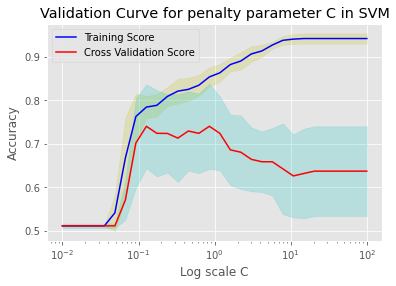

In [20]:
plt.semilogx(param_range, mean_train_score, label='Training Score', color='b')
plt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='y')
plt.semilogx(param_range, mean_valid_score, label='Cross Validation Score', color='r')
plt.fill_between(param_range, mean_valid_score - std_valid_score, mean_valid_score + std_valid_score, alpha=0.2, color='c')
plt.legend(loc='best')
plt.title('Validation Curve for penalty parameter C in SVM')
plt.xlabel('Log scale C')
plt.ylabel('Accuracy')
plt.show()

In [21]:
best_c_value = param_range[mean_valid_score.argmax()]
best_c_value

0.12689610031679222

Evaluation using confusion matrix

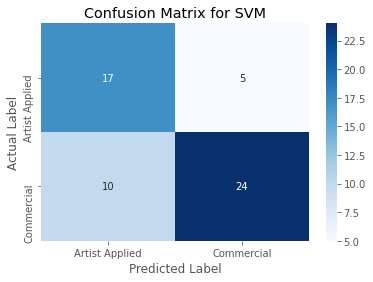

In [22]:
cm = confusion_matrix(y_valid, valid_prediction)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = ['Artist Applied', 'Commercial'],
            yticklabels = ['Artist Applied', 'Commercial'])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix for SVM')
plt.show()

### Train random forest classifier

In [100]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=10)
rfc.fit(X_train, y_train)
valid_prediction = rfc.predict(X_valid)
test_prediction = rfc.predict(X_test)
print("Training Accuracy:", rfc.score(X_train, y_train))
print("Holdout Accuracy:", rfc.score(X_valid, y_valid))

Training Accuracy: 0.9296875
Holdout Accuracy: 0.7857142857142857


Hyperparameter tuning for tree depth

In [44]:
param_range = np.arange(2, 20)
train_score, validation_scores = validation_curve(
    RandomForestClassifier(n_estimators=100), X, y, param_name='max_depth', cv=5,
    param_range=param_range, n_jobs=-1, verbose=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  90 | elapsed:    0.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.6s finished


In [45]:
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
mean_valid_score = np.mean(validation_scores, axis=1)
std_valid_score = np.std(validation_scores, axis=1)

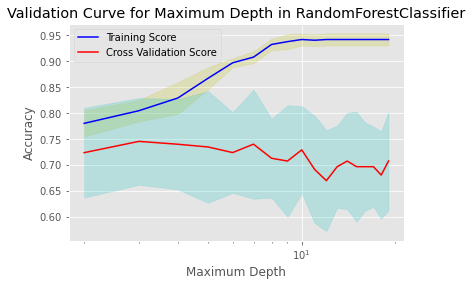

In [46]:
plt.semilogx(param_range, mean_train_score, label='Training Score', color='b')
plt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='y')
plt.semilogx(param_range, mean_valid_score, label='Cross Validation Score', color='r')
plt.fill_between(param_range, mean_valid_score - std_valid_score, mean_valid_score + std_valid_score, alpha=0.2, color='c')
plt.legend(loc='best')
plt.title('Validation Curve for Maximum Depth in RandomForestClassifier')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.show()

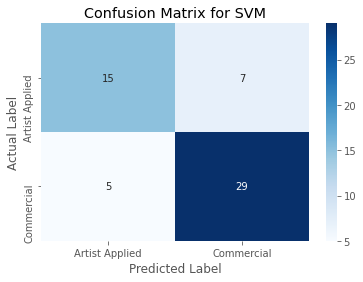

In [101]:
cm = confusion_matrix(y_valid, valid_prediction)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = ['Artist Applied', 'Commercial'],
            yticklabels = ['Artist Applied', 'Commercial'])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix for SVM')
plt.show()

### Fit logistic regression

In [153]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
valid_prediction = lr.predict(X_valid)
test_prediction = lr.predict(X_test)
print("Training Accuracy:", lr.score(X_train, y_train))
print("Holdout Accuracy:", lr.score(X_valid, y_valid))

Training Accuracy: 0.7890625
Holdout Accuracy: 0.75


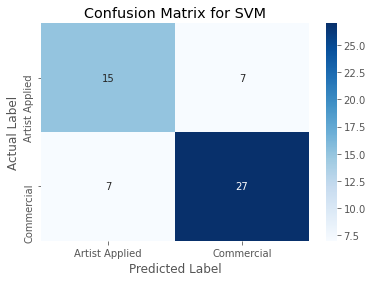

In [154]:
cm = confusion_matrix(y_valid, valid_prediction)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = ['Artist Applied', 'Commercial'],
            yticklabels = ['Artist Applied', 'Commercial'])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix for SVM')
plt.show()

### Stacking

In [138]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('BNB', BernoulliNB()),
    ('Logistic', LogisticRegression(C=0.8, max_iter=1000)),
    ('SVC', SVC(C=0.126896)),
    ('RF', RandomForestClassifier(max_depth=3, n_estimators=100)), 
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=1000)
)

clf.fit(X_train, y_train)
print('Stacking Training Accuracy:', clf.score(X_train, y_train))
print('Stacking Validation Accuracy:', clf.score(X_valid, y_valid))

Stacking Training Accuracy: 0.796875
Stacking Validation Accuracy: 0.7321428571428571
